# 이미지 캡셔닝

In [ ]:
!pip install -q transformers accelerate pillow torch torchvision
!pip install langchain langchain_openai langchain_community pypdf faiss-cpu chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 124.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 131.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.0/208.0 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 11.9 MB/s

## 1. 이미지 인식 모델

In [ ]:
from PIL import Image
import torch
import json
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor

model_name = "Qwen/Qwen2-VL-7B-Instruct"

# 모델 로드
Qwen_model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
Qwen_processor = AutoProcessor.from_pretrained(model_name)


`torch_dtype` is deprecated! Use `dtype` instead!
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


## 2. 이미지 확인

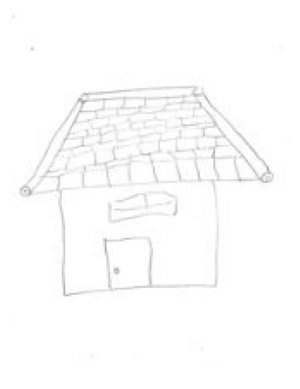

In [ ]:
import matplotlib.pyplot as plt

# 이미지 경로
image_path = "/content/test_집.JPG"
image = Image.open(image_path).convert("RGB")

# 이미지 시각화
plt.imshow(image)
plt.axis('off')
plt.show()

## 3. 캡션 생성

In [ ]:
prompt = "Describe in detail including object size, position"

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image,
            },
            {"type": "text", "text":prompt},
        ],
    }
]

text = Qwen_processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

inputs = Qwen_processor(
    text=[text],
    images=[image],  # 직접 이미지 리스트 전달
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# 생성
generated_ids = Qwen_model.generate(**inputs, max_new_tokens=1000)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = Qwen_processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text[0])

The image depicts a simple, hand-drawn illustration of a house. The house is depicted in a minimalist style with basic shapes and lines. Here are the details:

1. **Roof**: The roof is triangular and has a series of small, evenly spaced lines to represent shingles. The lines are evenly distributed across the roof, giving it a textured appearance.

2. **Body**: The body of the house is rectangular and has a door and a window. The door is located on the left side of the house, and the window is on the right side. Both the door and the window are represented by simple, rectangular shapes.

3. **Door**: The door is a small rectangle with a small square in the middle, possibly representing a doorknob or a handle.

4. **Window**: The window is a larger rectangle with a smaller rectangle inside it, indicating a window pane.

5. **Base**: The base of the house is a small rectangle that supports the body and the roof.

6. **Lines**: There are additional lines connecting the roof to the body of 

In [ ]:
#한글 프롬프트
output_korean = """
이 이미지는 손으로 그린 단순한 집의 일러스트를 묘사하고 있습니다. 집은 기본적인 모양과 선이 있는 미니멀리즘 스타일로 묘사되어 있습니다. 자세한 내용은 다음과 같습니다:

1. **지붕**: 지붕은 삼각형이며 대상포진을 나타내기 위해 작고 고르게 간격을 둔 일련의 선이 있습니다. 선들이 지붕 전체에 고르게 분포되어 있어 질감 있는 외관을 제공합니다.

2. **몸체**: 집의 몸체는 직사각형이며 문과 창문이 있습니다. 문은 집의 왼쪽에 있고 창문은 오른쪽에 있습니다. 문과 창문은 모두 단순한 직사각형 모양으로 표현되어 있습니다.

3. **문**: 문은 가운데에 작은 사각형이 있는 작은 직사각형으로, 문 손잡이나 손잡이를 나타낼 수 있습니다.

4. **창문**: 창문은 더 큰 직사각형이며, 그 안에 작은 직사각형이 있습니다. 이는 창문 창을 나타냅니다.

5. **베이스**: 집의 바닥은 몸체와 지붕을 지탱하는 작은 직사각형입니다.

6. **선**: 지붕과 집의 본체를 연결하는 추가 선들이 있으며, 이는 가장자리와 구조를 나타냅니다.

집의 전체 크기는 작고 페이지를 중심으로 배치되어 있습니다. 선은 얇고 흰색 배경에 검은색 잉크로 그림을 그렸습니다. 그림의 단순함은 어린이 그림일 수도 있고 스케치일 수도 있음을 시사합니다.
"""

# RAG

## 1. 전처리된 해석본 청킹

In [ ]:
import re
from langchain.schema import Document

# ✅ 1. txt 파일 불러오기
with open("/content/브런치 집_나무_사람 해석 수정본.txt", "r", encoding="utf-8") as f:
    text = f.read()

print("텍스트 로드 완료! 총 길이:", len(text))

# ✅ 2. 카테고리 자동 감지 함수
def detect_category(text):
    if "집" in text:
        return "집"
    elif "나무" in text:
        return "나무"
    elif "사람" in text:
        return "사람"
    else:
        return "기타"

import re
from langchain.schema import Document

# ✅ 3. 텍스트를 번호 단위로 1차 청킹
chunks = re.split(r'(?=\n?\d+\.)', text)
chunks = [chunk.strip() for chunk in chunks if chunk.strip()]

# ✅ 4. 각 청크에 카테고리 태깅 + '*' 기준 2차 청킹
langchain_docs = []
for i, chunk in enumerate(chunks):
    # '*' 기호가 있으면 추가로 분리
    if '*' in chunk:
        subchunks = re.split(r'(?=\*)', chunk)
        subchunks = [s.strip() for s in subchunks if s.strip()]
        for j, subchunk in enumerate(subchunks):
            category = detect_category(subchunk)
            langchain_docs.append(
                Document(
                    page_content=subchunk,
                    metadata={
                        "chunk_index": f"{i + 1}-{j + 1}",  # ex: 3-1, 3-2
                        "category": category
                    }
                )
            )
    else:
        category = detect_category(chunk)
        langchain_docs.append(
            Document(
                page_content=chunk,
                metadata={
                    "chunk_index": i + 1,
                    "category": category
                }
            )
        )

# ✅ 5. 결과 확인
print(f"총 {len(langchain_docs)}개 청크 생성 완료\n")
for doc in langchain_docs[:5]:  # 상위 5개만 미리보기
    print(f"[{doc.metadata['category']}] {doc.page_content[:120]}...")
    print("-" * 60)


텍스트 로드 완료! 총 길이: 52778
총 53개 청크 생성 완료

[기타] ﻿...
------------------------------------------------------------
[집] 1. 제목: HTP : 집
집은 일상생활에서의 가정생활, 또는 가족 내에서의 자신에 대한 인식을 나타낸다.
자신의 현실의 모습일 수도 있고, 또는 자신이 바라는 모습, 또는 가족의 생활패턴을 나타낸다....
------------------------------------------------------------
[사람] 1. 지붕




지붕의 핵심은 머리로 상상할 수 있는 생각을 나타낸다.




■ 과도하게 큰 지붕을 그린다
자신만의 환상을 가지고 있다
사회생활을 피하며 자신만의 상상에 몰두한다
■ 지붕이 그림의 전부인 것 마냥...
------------------------------------------------------------
[집] 2. 벽




벽은 나의 공간과 바깥 세상을 나누는 것으로, 나만의 안락한 장소를 나누는 기준이 됩니다.
이는 그림을 그리는 사람이 어떻게 사회에서 자신을 드러내는가, 또는 타인과 자신을 어떻게 구별하며 나타내는지...
------------------------------------------------------------
[집] 3. 문




문은 나만의 공간과 외부 세계를 잇는 통로이다. 즉 '나'라는 사람이 외부 환경과 어떻게 상호작용하며, 어떤 인간관계를 맺고 있는지 알려준다. 핵심적으로 내가 사회적으로 어떻게 사람들과 관계를 가지고...
------------------------------------------------------------


## 2. 카테고리 수정

In [ ]:
# 카테고리가 잘 들어갔는지 확인
for i, doc in enumerate(langchain_docs, start=1):
    print(f"{i}: {doc.metadata.get('category', '없음')}")

1: 기타
2: 집
3: 사람
4: 집
5: 집
6: 집
7: 집
8: 집
9: 집
10: 집
11: 나무
12: 나무
13: 집
14: 집
15: 집
16: 나무
17: 사람
18: 나무
19: 집
20: 사람
21: 사람
22: 사람
23: 집
24: 사람
25: 집
26: 집
27: 사람
28: 집
29: 사람
30: 사람
31: 사람
32: 기타
33: 사람
34: 기타
35: 사람
36: 사람
37: 집
38: 사람
39: 사람
40: 기타
41: 사람
42: 집
43: 집
44: 집
45: 집
46: 집
47: 기타
48: 집
49: 집
50: 기타
51: 기타
52: 집
53: 사람


In [ ]:
# 카테고리 수정
for i, doc in enumerate(langchain_docs, start=1):
    if 0 <= i <= 10:
        doc.metadata['category'] = '집'
    elif 11 <= i <= 18:
        doc.metadata['category'] = '나무'
    elif 19 <= i :
        doc.metadata['category'] = '사람'


In [ ]:
# 수정된 카테고리
for i, doc in enumerate(langchain_docs, start=1):
    print(f"{i-1}: {doc.metadata.get('category', '없음')}")

0: 집
1: 집
2: 집
3: 집
4: 집
5: 집
6: 집
7: 집
8: 집
9: 집
10: 나무
11: 나무
12: 나무
13: 나무
14: 나무
15: 나무
16: 나무
17: 나무
18: 사람
19: 사람
20: 사람
21: 사람
22: 사람
23: 사람
24: 사람
25: 사람
26: 사람
27: 사람
28: 사람
29: 사람
30: 사람
31: 사람
32: 사람
33: 사람
34: 사람
35: 사람
36: 사람
37: 사람
38: 사람
39: 사람
40: 사람
41: 사람
42: 사람
43: 사람
44: 사람
45: 사람
46: 사람
47: 사람
48: 사람
49: 사람
50: 사람
51: 사람
52: 사람


문서의 최eo 길이 : 4246
문서의 최소 길이 : 1
문서의 평균 길이 : 990.6603773584906


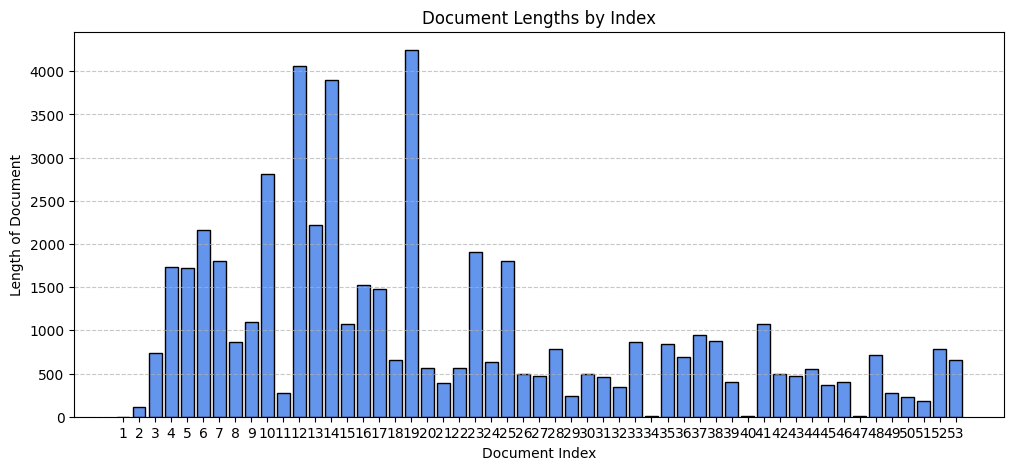

In [ ]:
import matplotlib.pyplot as plt

# 각 문서 길이 계산 (문자 수 기준)
doc_lengths = [len(doc.page_content) for doc in langchain_docs]

# 문서 최소, 평균 길이 출력
print('문서의 최eo 길이 :', max(doc_lengths))
print('문서의 최소 길이 :', min(doc_lengths))
print('문서의 평균 길이 :', sum(doc_lengths) / len(doc_lengths))

# 문서 인덱스 (1, 2, 3, …)
doc_indices = range(1, len(langchain_docs) + 1)

# 막대그래프 그리기
plt.figure(figsize=(12, 5))
plt.bar(doc_indices, doc_lengths, color='cornflowerblue', edgecolor='black')
plt.xlabel('Document Index')
plt.ylabel('Length of Document')
plt.title('Document Lengths by Index')
plt.xticks(doc_indices)  # 문서 번호 표시
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 임베딩 모델 & 벡터 DB

In [ ]:
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import RetrievalQA
from langchain_core.documents import Document
from langchain import PromptTemplate
from langchain.chat_models import ChatOpenAI

In [ ]:
import os
from google.colab import userdata
from openai import OpenAI

# 환경 변수로 설정
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
client = OpenAI()

In [ ]:
embedding = OpenAIEmbeddings()

vectordb = Chroma.from_documents(
    collection_name="your_collection_name",
    documents=langchain_docs,
    embedding=embedding)

# 벡터DB의 개수 확인
vectordb._collection.count()

106

In [ ]:
# 문서 로드
documents = vectordb._collection.get()['documents']
print('문서의 개수 :', len(documents))
print('-' * 100)
print('첫번째 문서 출력 :', documents[1])

문서의 개수 : 53
----------------------------------------------------------------------------------------------------
첫번째 문서 출력 : 1. 제목: HTP : 집
집은 일상생활에서의 가정생활, 또는 가족 내에서의 자신에 대한 인식을 나타낸다.
자신의 현실의 모습일 수도 있고, 또는 자신이 바라는 모습, 또는 가족의 생활패턴을 나타낸다.


In [ ]:
# 유사도가 높은 문서 5개만 추출. k = 5
retriever = vectordb.as_retriever(search_kwargs={"k": 5})

top_5_docs = retriever.get_relevant_documents(output_korean)
print('유사 문서 개수 :', len(top_5_docs))
print('--' * 20)
for doc in top_5_docs:
  print(doc)
  print('--')

/tmp/ipython-input-985033223.py:4: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  top_5_docs = retriever.get_relevant_documents(output_korean)


유사 문서 개수 : 5
----------------------------------------
page_content='7. 집의 특징




이 외의 집을 표현하며 독특하고 특징적인 표현들을 관찰해야 한다.




■ 집 틀의 빗물받이, 또는 홈통과 같은 파이프를 강조한다.
타인을 방어하고자 하거나 회피하려는 의심을 품고 있다.
■ 집의 전체적인 모양이 부적절하게 틀어져 있고, 선이 구불거리며 각 집의 다양한 요소들이 어색하게 그려져 있다.
선천적으로 신체적 어려움 및 정신적인 어려움을 겪고 있을 수 있다. 단 이것이 신체적 어려움 및 정신적 어려움을 판단하는 진단기준이 되어서는 안 된다.
■ 집을 사람처럼 살아있다고 표현한다.
아동의 경우, 정상적인 경우가 있다.
청소년 및 성인의 경우, 어리광이 심하거나 또는 사회적으로 부적응하는 모습을 나타내고자 하는 경우가 있다.
선천적으로 신체적 어려움 및 정신적인 어려움을 겪고 있을 수 있다. 단 이것이 신체적 어려움 및 정신적 어려움을 판단하는 진단기준이 되어서는 안 된다.
■ 집의 청사진을 그리거나 집의 평면도를 그린다
집안 가족들과 지내면서 심각한 가족적인 문제를 겪고 있거나, 극도로 충격적인 사건을 겪은 적이 존재한다.
만약 청사진이나 평면도를 깔끔하고 완벽히 그린 경우, 극도로 무언가를 경계하며 의심하는 태도를 가지고 있다. (이와 같은 경우, "자신의 삶을 통제"하고 싶어하거나 "타인이 나에게 입히는 피해"에 집착할 수 있다.)
만약 청사진이나 평면도를 흐리멍덩하거나 부적절하게 그린 경우, 선천적으로 신체적 어려움 및 정신적인 어려움을 겪고 있을 수 있다. 단 이것이 신체적 어려움 및 정신적 어려움을 판단하는 진단기준이 되어서는 안 된다.
■ 집의 뒷면, 반대편의 집의 모습을 그린다
무언가로부터 도망치고 그만두려는 마음이 존재한다
반항하고 경험들을 부정적으로 바라보려 하는 태도가 보인다
완벽하려고 노력하며 타인으로부터 입는 피해에 대하여 극도로 민감하게 반응한다
■ 집의 모양이 둥그스름하며 흐리멍덩한 

In [ ]:
template = """당신은 심리를 해석해주는 챗봇입니다.

주어진 검색 결과를 바탕으로 답변하세요.

1. 당신은 오직 위에서 제공된 참고 자료에 있는 사실 정보에만 근거해 사용자 질문에 답변해야 하며, 절대 지어내거나 허구의 정보를 포함해서는 안 됩니다.
2. 만약 사용자의 질문을 명확히 하는 것이 답변에 도움이 된다면, 질문을 시도할 수 있습니다.
3. 만약 참고 자료에 있는 정보로 질문에 충분히 답변할 수 없다면, 다음의 문장을 그대로 답변으로 사용해야 합니다: "죄송합니다. 참고 자료에는 요청하신 질문에 답변할 만한 충분한 정보가 없네요.".
4. 만약 답변에 참고 자료의 내용을 인용했다면, 답변에 사용한 문장이나 문단 끝마다 해당 참고 자료의 Source_id를 반드시 추가해야 합니다. Source_id 값은 참고 자료에서 가져오며, 두 개의 대괄호로 감싸야 합니다. 예시: [[page_21.png]], [[page_29.png]]
5. 반드시 한국어로 1인칭 시점에서 정확하고 엄격한 스타일로 답변해야 하며, 사실을 기반으로 상세히 설명해야 합니다.

{context}

Question: {question}
Answer:
"""

prompt = PromptTemplate.from_template(template)

In [ ]:
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type_kwargs={"prompt": prompt},
    retriever=retriever,
    return_source_documents=True)

/tmp/ipython-input-1433469987.py:1: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name="gpt-4o", temperature=0)


In [ ]:
def get_chatbot_response(input_text):
    chatbot_response = qa_chain.invoke(input_text)
    return chatbot_response['result'].strip()

In [ ]:
input_text = output_korean
result = get_chatbot_response(input_text)
print(result)

이 그림은 단순한 집의 일러스트로, 미니멀리즘 스타일로 묘사되어 있습니다. 지붕은 삼각형 모양으로, 고르게 간격을 둔 선들이 있어 질감 있는 외관을 제공합니다. 이는 지붕을 단순한 직선으로 표현한 것으로, 매우 경직되어 있으며 남에게 잘 어울리지 못하는 성향을 나타낼 수 있습니다[[page_21.png]].

집의 몸체는 직사각형으로, 문과 창문이 단순한 직사각형 모양으로 표현되어 있습니다. 이는 기본적인 생활이나 생리 욕구가 원활하지 않음을 나타낼 수 있으며, 특히 '내가 다른 사람인 것처럼 느낌'을 받거나 '현실세상에서 벗어나 다른 세상으로 사는 느낌'을 느낄 수 있는 상태를 시사할 수 있습니다[[page_21.png]].

문과 창문이 각각 왼쪽과 오른쪽에 위치한 것은, 심리적으로 일상생활에서 도피하려는 시도일 수 있으며, 무언가에 반항하거나 저항하려는 시도를 나타낼 수 있습니다[[page_21.png]].

이 그림의 단순함은 어린이의 그림일 수도 있고 스케치일 수도 있음을 시사하며, 이는 그림을 그린 사람의 심리 상태를 더 깊이 이해하기 위해 추가적인 정보가 필요할 수 있음을 의미합니다. 전체적으로 이 그림은 기본적인 형태와 선을 통해 그린 사람의 심리적 상태를 간단히 나타내고 있습니다.
